Extracting ./image_data/MNIST/raw/train-images-idx3-ubyte.gz to ./image_data/MNIST/raw


Extracting ./image_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./image_data/MNIST/raw


Extracting ./image_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./image_data/MNIST/raw




Extracting ./image_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./image_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


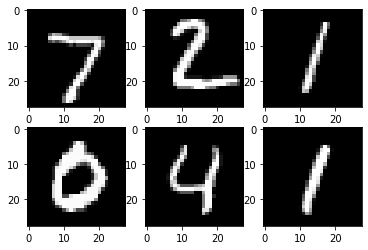

Epoch [1/5], Step [100/600]
Average accuracy: 0.7985, Average loss: 0.7321
Epoch [1/5], Step [200/600]
Average accuracy: 0.9107, Average loss: 0.2947
Epoch [1/5], Step [300/600]
Average accuracy: 0.9380, Average loss: 0.2159
Epoch [1/5], Step [400/600]
Average accuracy: 0.9431, Average loss: 0.1909
Epoch [1/5], Step [500/600]
Average accuracy: 0.9520, Average loss: 0.1570
Epoch [1/5], Step [600/600]
Average accuracy: 0.9600, Average loss: 0.1359
Epoch [2/5], Step [100/600]
Average accuracy: 0.9651, Average loss: 0.1129
Epoch [2/5], Step [200/600]
Average accuracy: 0.9676, Average loss: 0.1050
Epoch [2/5], Step [300/600]
Average accuracy: 0.9698, Average loss: 0.0918
Epoch [2/5], Step [400/600]
Average accuracy: 0.9711, Average loss: 0.0945
Epoch [2/5], Step [500/600]
Average accuracy: 0.9719, Average loss: 0.0966
Epoch [2/5], Step [600/600]
Average accuracy: 0.9719, Average loss: 0.0932
Epoch [3/5], Step [100/600]
Average accuracy: 0.9816, Average loss: 0.0610
Epoch [3/5], Step [200/60

In [1]:
###########################################################################################
# Import libraries needed
###########################################################################################
import torchvision.transforms as transforms                 # Import transformations we will apply to data when loading dataset
import torchvision                                          # For downloading dataset
import torch                                                # For getting an iterable over dataset
import torch.nn as nn                                       # For architecture and loss function
import torch.nn.functional as F                             # For activation function

import matplotlib.pyplot as plt                             # For visualizing a sample of the dataset


###########################################################################################
# Device configuration
###########################################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


###########################################################################################
# Declare global variables and hyper-parameters (to be fine tuned)
###########################################################################################
num_epochs = 5          # How many times to iterate through the entire dataset
batch_size = 100        # How many images to process at a time
learning_rate = 0.001   # How quickly to make changes in optimization function


###########################################################################################
# Import/download actual data and apply transforms for data processing
# Also put dataset into data loader so we can iterate through data
###########################################################################################
# Import training and testing data
train_dataset = torchvision.datasets.MNIST(root='./image_data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./image_data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Place training and testing data into dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

###########################################################################################
# Visualize a few samples of the data
###########################################################################################
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()


###########################################################################################
# Declare architecture/class of neural network
###########################################################################################
input_size = 784        # Images are 28 pixels by 28 pixels and have 1 color channel 
                        #   so input_size = 1x28x28=684
hidden_size1 = 500      # Size of hidden layer 1
hidden_size2 = 250      # Size of hidden layer 2
hidden_size3 = 100      # Size of hidden layer 3
num_classes = 10        # Different categories for digits to be classified into 
                        #   (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

# Architecture of neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        # Make sure we have correct inheritance from parent
        super(NeuralNetwork, self).__init__()
        
        # Declare layers
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.layer4 = nn.Linear(hidden_size3, num_classes)

        # Declare activation function
        self.activation = nn.ReLU()

    def forward(self, input):
        toReturn = self.layer1(input)
        toReturn = self.activation(toReturn)
        
        toReturn = self.layer2(toReturn)
        toReturn = self.activation(toReturn)

        toReturn = self.layer3(toReturn)
        toReturn = self.activation(toReturn)
        
        toReturn = self.layer4(toReturn)
        return toReturn


###########################################################################################
# Create instance of neural network and name it model AND push it to device (cuda if applicable)
###########################################################################################
model = NeuralNetwork().to(device)


###########################################################################################
# Declare loss and optimizer functions
###########################################################################################
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  


###########################################################################################
# Training loop
###########################################################################################
# Iterate through entire training dataset "num_epochs" number of times
running_number_samples = 0
running_number_correct = 0
running_loss = 0
running_loss_num_times_updated = 0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    # When iterating through training dataset, process batch_size number of images at a time
    for i, (images, labels) in enumerate(train_loader):
        # Original size of images is: [100, 1, 28, 28]
        #   because batch_size is 100, images have 1 color channel, and images are 28 pixels by 28 pixels
        # Since we are using linear layers, we need to reshape our data
        #   into shape: batch_size, product_of_all_other_sizes
        # Also need to move images to cuda device (if applicable) to achieve speedup
        images = images.reshape(-1, 1*28*28).to(device)

        # Move labels to cuda device (if applicable) to achieve speedup
        labels = labels.to(device)

        # Perform forward pass
        outputs = model(images)

        # Keep track of number correct so we can print accuracy every 100 iterations
        _, predicted = torch.max(outputs.data, 1)
        running_number_samples += labels.size(0)
        running_number_correct += (predicted == labels).sum().item()
        
        # Calculate loss by comparing predicted to actual
        loss = criterion(outputs, labels)

        # Keep track of loss so we can print running/avg loss every 100 iterations
        running_loss += loss.item()
        running_loss_num_times_updated += 1

        # Perform backward pass/back propogation/optimization
        optimizer.zero_grad() # always remember to zero out the gradient to prevent gradients from 
                              #     previous iterations from affecting this iteration
        loss.backward()
        optimizer.step()

        
        if (i+1) % 100 == 0:
            avg_running_accuracy = running_number_correct/running_number_samples
            avg_running_loss = running_loss/running_loss_num_times_updated

            # Print epoch and step number
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}]')

            # Print avg accuracy and avg loss
            print (f'Average accuracy: {avg_running_accuracy:.4f}, Average loss: {avg_running_loss:.4f}')
            avg_running_accuracy = 0
            avg_running_loss = 0

            running_number_correct = 0
            running_number_samples = 0
            running_loss = 0
            running_loss_num_times_updated = 0



###########################################################################################
# Evaluation of model's accuracy
###########################################################################################

# Use torch.no_grad() to tell PyTorch that gradients don't need to be calculated (makes computations faster)
#   because we aren't optimizing when we evaluate our model
with torch.no_grad():
    total_number_correct = 0
    total_number_samples = 0
    for images, labels in test_loader:
        # Do reshaping as necessary and put both images+labels onto cuda (if available)
        images = images.reshape(-1, 1*28*28).to(device)
        labels = labels.to(device)

        # Use model to get predictions
        outputs = model(images)

        # Get the actual outputs by using max
        # Since max returns in the format of (value, index) and we don't need value,
        #   we can just use a placeholder like _ in place of value
        _, predicted = torch.max(outputs.data, 1)
        
        # Update total number of samples and total number correct
        total_number_samples += labels.size(0)
        total_number_correct += (predicted == labels).sum().item()
    
    final_accuracy = 100.0*(total_number_correct / total_number_samples)
    print(f'Final network accuracy on 10000 test images: {final_accuracy}%')